In [1]:
import sys
import matplotlib.pyplot as plt

import numpy as np

import scipy
from scipy.integrate import solve_ivp

print (sys.version)

3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]


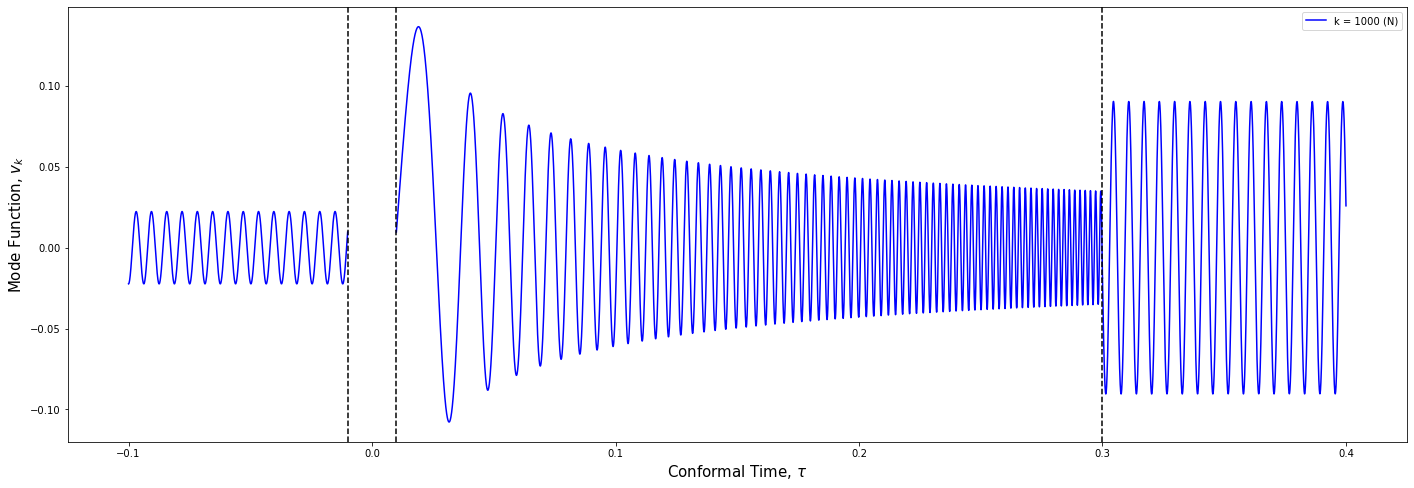

In [33]:
#times
t_start = -1e-1
t_r = 1e-2
t_m = 3e-1
t_end = 4e-1


#t, conformal time
def infl_derivs(m_g, k, H_i):
    def wrapper(t, y):
        v = y[0]
        q = y[1]
        return [q, -( k**2 + (m_g / (H_i * t))**2 - (2 / t**2) ) * v]
    return wrapper

def massdom_derivs(m_g, k, H_i):
    def wrapper(t, y):
        v = y[0]
        q = y[1]
        return [q, -( (1e4 * t * m_g)**2 ) * v]
    return wrapper

def massless_derivs(m_g, k, H_i):
    def wrapper(t, y):
        v = y[0]
        q = y[1]
        return [q, -(k**2) * v]
    return wrapper


#y_init_func: given k, return pair for initial v and v'
def simulator(pltTogether, analytic_tuple, m_g, H_i, kList, colorList, confTimeTuple, deriv_func, y_init_func, x_label, y_label, title):
    #plotting setup
    if not pltTogether:
        sc = 8
        plt.figure(figsize=(sc * 3, sc * 1))
#         plt.xscale('log', base = 10)
        plt.xlabel(x_label, fontsize = 15)
        plt.ylabel(y_label, fontsize = 15)
        plt.title(title, fontsize = 15)
        
    #range of eta values (remember, needs to be negative for inflation phase)
    ct_range = np.linspace(confTimeTuple[0], confTimeTuple[1], confTimeTuple[2])
    
    #key: k, value: tuple w v, v' at end of ct_range (return for junction conditions)
    junc_dict = {}
    
    #plotting the passed in k values
    for i in range(len(kList)):        
        
        sol = solve_ivp(deriv_func(m_g, kList[i], H_i), t_span = [ct_range[0], ct_range[-1]], y0 = y_init_func(kList[i]), t_eval = ct_range)
        if pltTogether:
            plt.plot(sol.t, sol.y[0], colorList[i])
        else:
            plt.plot(sol.t, sol.y[0], colorList[i], label = "k = " + str(kList[i]) + " (N)")
        
        #store end vals for junc cond
        junc_dict[kList[i]] = (sol.y[0][-1], sol.y[1][-1])
        
        #analytic solution: inflationary
        if analytic_tuple[0]:
            nu = np.sqrt((9 / 4) - (m_g / H_i)**2)
            v_a = (np.sqrt(-np.pi * ct_range) / 2) * scipy.special.hankel1(nu, - kList[i] * ct_range)
            plt.plot(ct_range, v_a, colorList[i] + "-", label = "k = " + str(kList[i]) + " (A)")
            
        #analytic solution: mass dominant
        if analytic_tuple[1]:
            nu = np.sqrt((9 / 4) - (m_g / H_i)**2)
            #recall tau_r = 1e-2
            C_pre = -1j * np.sqrt(np.pi) * (2**(-3.5 + nu)) * ((kList[i] * t_r)**(-nu)) * scipy.special.gamma(nu)
            C1 = C_pre * ((2 * m_g / H_i) * (scipy.special.jv(-0.75, m_g / (2 * H_i))) + (1 - 2 * nu) * (scipy.special.jv(0.25, m_g / (2 * H_i))))
            C2 = C_pre * ((2 * m_g / H_i) * (scipy.special.jv(0.75, m_g / (2 * H_i))) - (1 - 2 * nu) * (scipy.special.jv(-0.25, m_g / (2 * H_i))))
            
            def a_t(t):
                return 1e4 * t
            
            v_b = (2 / np.sqrt(np.pi * m_g * a_t(ct_range))) * ((C1 * np.cos((a_t(ct_range) * m_g * ct_range / 2) - (np.pi / 8))) + (C2 * np.cos((a_t(ct_range) * m_g * ct_range / 2) + (np.pi / 8))))
#             plt.plot(ct_range, v_b, colorList[i] + "-", label = "k = " + str(kList[i]) + " (A)")
            plt.plot(ct_range, v_b, "r", label = "k = " + str(kList[i]) + " (A)")
    
        #analytic solution: massless
        if analytic_tuple[2]:
            D1 = -np.sin(kList[i]*t_m) * ()
        
        
    #plot legend
    plt.legend()
    
    return junc_dict


kvals = [1000]
cols = ["b-", "r-", "g-", "c", "m", "y", "k"][:len(kvals)]

#inflationary phase
infl_dict = simulator(False, (False, False), 1, 1, kvals, cols, (t_start, -t_r, 5000), infl_derivs, lambda k: (-1 / np.sqrt(2 * k), 0), r"Conformal Time, $\tau$", r"Mode Function, $v_k$", "")

#mass-dominant phase
massdom_dict = simulator(True, (False, False), 1, 1, kvals, cols, (t_r, t_m, 5000), massdom_derivs, lambda k: infl_dict[k], "", "", "")

#massless phase
massless_dict = simulator(True, (False, False), 1, 1, kvals, cols, (t_m, t_end, 5000), massless_derivs, lambda k: massdom_dict[k], "", "", "")


#inflationary -> mass dominant
plt.axvline(-t_r, color = "black", linestyle = "dashed")
plt.axvline(t_r, color = "black", linestyle = "dashed")

#mass dominant -> massless
plt.axvline(t_m, color = "black", linestyle = "dashed")


plt.legend()

-0.02446921116691992j
